必要な機能

元画像の読み込みと処理
マッピングされた画像の読み込み
バウンティボックスの情報の読み込み
処理後のバウンティボックスの座標の算出
指標の算出（2つ）

In [244]:
from torchvision import transforms
from PIL import Image
import xml.etree.ElementTree as ET
import numpy as np


class Experience_bounding_box():
    
    def __init__(self) -> None:
        """
        初期化
        """
        self.transform = transforms.Compose(
            [
                transforms.Resize(256),  # (256, 256) で切り抜く。
                transforms.CenterCrop(224),  # 画像の中心に合わせて、(224, 224) で切り抜く
            ]
        )

 
    def open_and_resize_original_image(self, img_path : str) -> Image.Image:
        """
        img_pathの元画像を読み込んでサイズを(244, 244)にして返す
        """
        original_image = Image.open(img_path)
        original_image = self.transform(original_image)
        
        return original_image
    
    
    def open_result_image(self, img_path : str) -> Image.Image:
        """
        img_pathのマッピングされた画像を読み込んで返す（サイズの変更はしない）
        """
        result_image = Image.open(img_path)
        
        return result_image
    
    
    def get_image_size_and_bounding_box_cornerpoints(self, file_path : str) -> list[tuple]:
        """
        file_pathのxmlファイルから画像サイズとバウンディングボックスの座標を読み込んで返す
        [(height, width), (ymin, ymax, xmax, xmin)]
        """
        xml_file = open(file_path)
        xmll_tree = ET.parse(xml_file)
        root = xmll_tree.getroot()
        for obj in root.iter("size"):
            h = int(obj.find("height").text)
            w = int(obj.find("width").text)
        
        for obj in root.iter('object'):
            xmlbox = obj.find("bndbox")
            ymin = int(xmlbox.find('ymin').text)
            ymax = int(xmlbox.find('ymax').text)
            xmin = int(xmlbox.find('xmin').text)
            xmax = int(xmlbox.find('xmax').text)
        
        
        return [(h, w), (ymin, ymax, xmin, xmax)]
            
    
       
    def get_resized_box_corner(self, original_size : tuple, original_corner_points : tuple) -> list:
        """
        original_cornerで表されるバウンディングボックスを持つ、サイズがoriginal_size(y, x)の画像が(224, 224)にresizeした後の、
        バウンディングボックスのの座標を返す
        [ymin, ymax, xmax, xmin]
        """
        h, w = original_size
        ymin, ymax, xmin, xmax = original_corner_points
        
        # xmlファイルの座標は右下原点(?)なので上下左右に反転させて左上原点に直す
        ymin = h - ymin - 1
        ymax = h - ymax - 1
        xmin = w - xmin - 1
        xmax = w - xmax - 1
        
        # transforms.Resize(256)に相当する座標変換を行う
        tmp = min(h, w)
        ymin = ymin * 256 // tmp
        ymax = ymax * 256 // tmp
        xmin = xmin * 256 // tmp
        xmax = xmax * 256 // tmp
        
        # transforms.CenterCrop(224)に相当する座標変換を行う
        tmp = (256 - 224) // 2
        ymin -= tmp
        ymax -= tmp
        xmin -= tmp
        xmax -= tmp
        
        return [ymin, ymax, xmin, xmax]
    
    
    def cal_val(self, original_img_path : str, result_img_path : str, xml_path : str) -> list[tuple]:
        # 元画像の読み込みと処理
        original_img = self.open_and_resize_original_image(original_img_path)
        # マッピングされた画像の読み込み
        result_img = self.open_result_image(result_img_path)
        # xmlファイルから元画像のサイズと4つの座標の読み込み
        original_img_size, bndbox_coordinates = self.get_image_size_and_bounding_box_cornerpoints(xml_path)
        # 返還後のバウンディングボックスの4つの頂点の座標の算出
        ymin, ymax, xmin, xmax = self.get_resized_box_corner(original_img_size, bndbox_coordinates)
        
        count_in_bndbox = [0, 0] # バウンディングボックスの中のマッピングされた割合を記録するためのリスト. 0でマッピングされている, 1でマッピングされていない
        count_mapped = [0, 0] # マッピングされた領域のうち、バウンディングボックスの内外にある割合を記録するためのリスト. 0でバウンディングボックスの内側（境界含む）, 1でバウンディングボックスの外側
        
        for i in range(224):
            for j in range(224):
                if original_img.getpixel((i, j)) != result_img.getpixel((i, j)): # マッピングされている
                    if ymin <= i <= ymax and xmin <= j <= xmax: # バウンディングボックスの内側
                        count_in_bndbox[0] += 1
                        count_mapped[0] += 1
                    else:# バウンディングボックスの外側
                        count_mapped[1] += 1
                elif ymin <= i <= ymax and xmin <= j <= xmax: # マッピングされていないかつバウンディングボックスの内側
                    count_in_bndbox[1] += 1
        
        a, b = count_in_bndbox
        count_in_bndbox.append(a * 100 / (a + b))
        a, b = count_mapped
        count_mapped.append(a * 100 / (a + b))
        
        return[tuple(count_in_bndbox), tuple(count_mapped)]
                    
                        
                        
        
        
        
        
        
        
        
        

In [245]:
exp1 = Experience_bounding_box()

In [246]:
original_corner = exp1.get_bounding_box_corner("xmls/Abyssinian_13.xml")
resized_corner = exp1.get_resized_box_corner((245, 280), original_corner)

280 245
(3, 3, 3) (148, 61)
(2, 2, 2) (148, 134)
(1, 1, 1) (219, 61)
(0, 0, 0) (219, 134)


In [191]:
original_corner

[(25, 145), (25, 218), (96, 145), (96, 218)]

In [225]:
245 - 25 - 1, 245 - 96 - 1, 280 - 145 - 1, 280 - 218 - 1

(219, 148, 134, 61)

In [211]:
280 * 256 // 245

292

In [210]:
resized_corner.size

(256, 292)

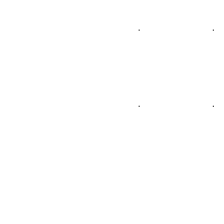

In [201]:
resized_corner

In [214]:
148 / 245 * 256

154.64489795918368

In [222]:
148 * 256 / 245

154.64489795918368

回転させた後のy/x座標 * (256 * 画像のy/xのサイズ / 画像のy/xサイズの小さい方) / 画像のy/xのサイズ
= 回転させた後のy/x座標 * 256 / 画像のy/xサイズの小さい方

In [221]:
61 * 256 / 245

63.73877551020408

In [213]:
for i in range(224):
    for j in range(224):
        tmp = resized_corner.getpixel((i, j))
        if tmp != (255, 255, 255):
            print(tmp,(i, j))

(219, 219, 219) (154, 63)
(196, 196, 196) (154, 64)
(231, 231, 231) (154, 139)
(185, 185, 185) (154, 140)
(188, 188, 188) (155, 63)
(143, 143, 143) (155, 64)
(209, 209, 209) (155, 139)
(122, 122, 122) (155, 140)


In [193]:
for i in range(224):
    for j in range(224):
        tmp = resized_corner.getpixel((i, j))
        if tmp != (255, 255, 255):
            print(tmp,(i, j))

(219, 219, 219) (154, 63)
(196, 196, 196) (154, 64)
(231, 231, 231) (154, 139)
(185, 185, 185) (154, 140)
(188, 188, 188) (155, 63)
(143, 143, 143) (155, 64)
(209, 209, 209) (155, 139)
(122, 122, 122) (155, 140)


In [195]:
resized_corner.size

(256, 292)

In [94]:
tmp = Image.new("L", (100, 100), 255)

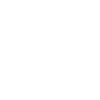

In [95]:
tmp

In [96]:
for i in range(100):
    for j in range(100):
        if (i + j) % 5 == 0:
            tmp.putpixel((i, j), 0)

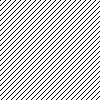

In [97]:
tmp